# Load Packages

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import randint, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Model Tuning
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

import xgboost as xgb
import lightgbm as lgb


from sklearn.ensemble import BaggingClassifier, BaggingRegressor

from sklearn import set_config
# set_config(display='diagram')

import os
import psutil


import warnings
# warnings.filterwarnings('ignore')

# Ignore the warning
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

# Load Data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png" width=600>

> Data Readme
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## Load RAW data

In [264]:
# set data source
data_url = 'data/train.csv'

# set index column
index_col = 'Id'

# load data
data = pd.read_csv(data_url, index_col=index_col)
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Feature-Target split

In [265]:
# define the target column in the train dataset
target = 'SalePrice'

# split columns into X and y
X = data.drop(columns = target).copy()
y = data[target]

# check the shape of the data
print(f'shape of X is \033[94m{X.shape}\033[0m, shape of y is \033[94m{y.shape}\033[0m')

shape of X is (1460, 79), shape of y is (1460,)


## Missing Values Inspection

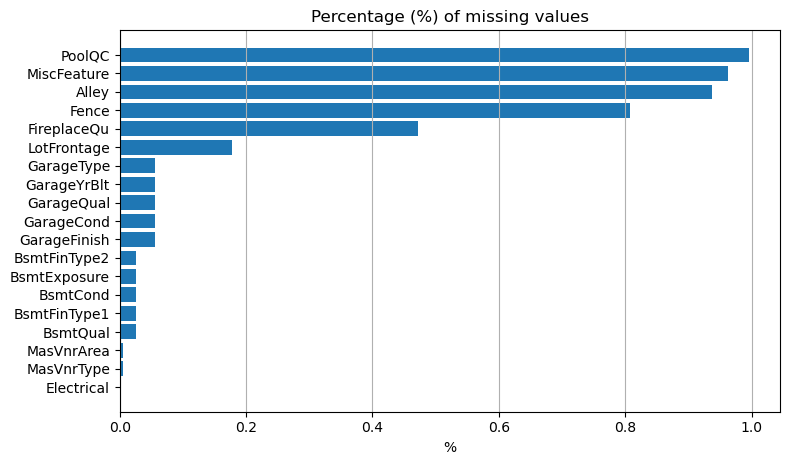

In [266]:
#filter all the features with missing values
feature_null= X.isnull().mean().sort_values(ascending = False)
feature_null=feature_null[feature_null>0]

# visualize
plt.figure(figsize=(8, feature_null.shape[0]/4))
feature_ranks = range(len(feature_null))
bar = plt.barh(feature_null.index, feature_null.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Percentage (%) of missing values")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

## Feature Selection

In [267]:
X = data.drop(columns = target).copy()
features_all = X.columns.sort_values().to_list()

columns_to_drop = [
    #to many missing values
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 
    #
    '3SsnPorch', 'BsmtFinSF2','BsmtHalfBath', 'EnclosedPorch','LowQualFinSF', 'MiscVal', 'PoolArea', 'ScreenPorch', 
    'Condition2', 'Functional', 'GarageCond',  'GarageQual', 'Heating','LandSlope','RoofMatl', 'Street', 'Utilities'
    ''
]
# columns_to_drop = []
X = X.drop(columns=columns_to_drop)

feature_numerical = X.select_dtypes(exclude='object').columns.sort_values().to_list()

# Numerical features following uniform distrution
feature_numerical_norm = ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 
                          'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']
# feature_numerical_norm = []

feature_numerical_uniform = [key for key in feature_numerical 
                              if key not in feature_numerical_norm]

feature_categorical = X.select_dtypes(include='object').columns.sort_values().to_list()

feature_categorical_Ordinal = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'FireplaceQu', 'HeatingQC', 'KitchenQual'
]
feature_categorical_Ordinal.sort()
# feature_categorical_Ordinal=[]

feature_categorical_OneHot = [key for key in feature_categorical 
                              if key not in feature_categorical_Ordinal]

print('--------OVERVIEW----------')

print(f'All features (\033[95m{len(features_all)}\
\033[0m): \033[94m{features_all}\033[0m')

print(f'Features to drop (\033[91m{len(columns_to_drop)}\
\033[0m): \033[94m{columns_to_drop}\033[0m')

print('--------CATEGORICAL----------')

print(f'Categorical cat features (\033[95m{len(feature_categorical)}\
\033[0m): \033[94m{feature_categorical}\033[0m')

print(f'Ordinal cat features (\036[95m{len(feature_categorical_Ordinal)}\
\033[0m): \033[94m{feature_categorical_Ordinal}\033[0m')

print(f'None-ordinal cat features (\033[95m{len(feature_categorical_OneHot)}\
\033[0m): \033[94m{feature_categorical_OneHot}\033[0m')

print('---------NUMERICAL---------')

print(f'Numerical features (\033[95m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')

--------OVERVIEW----------
All features (79): ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleTyp

# Data Exploration

## Distribution of each numerical feature

Numerical features (28): ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtUnfSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
Numerical features (20): ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFullBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'HalfBath', 'KitchenAbvGr', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
Numerical features (8): ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']


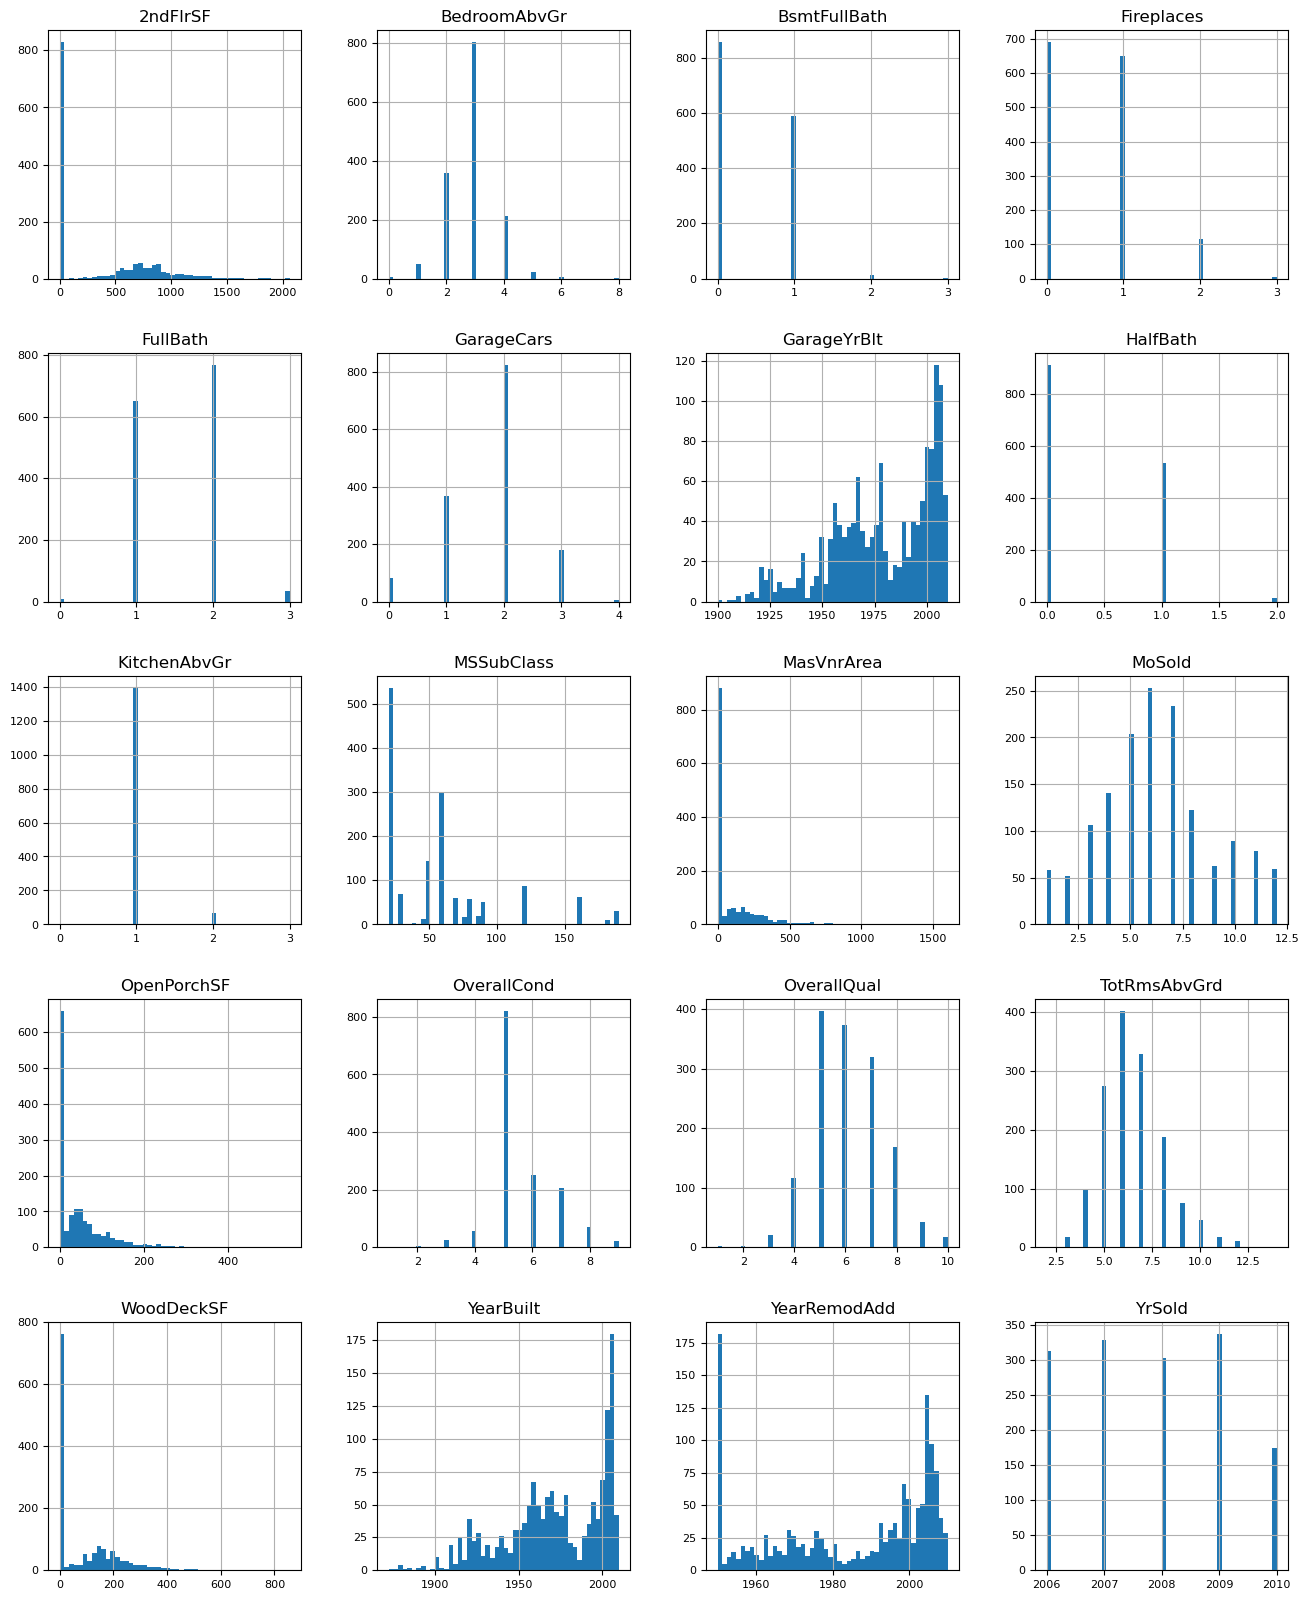

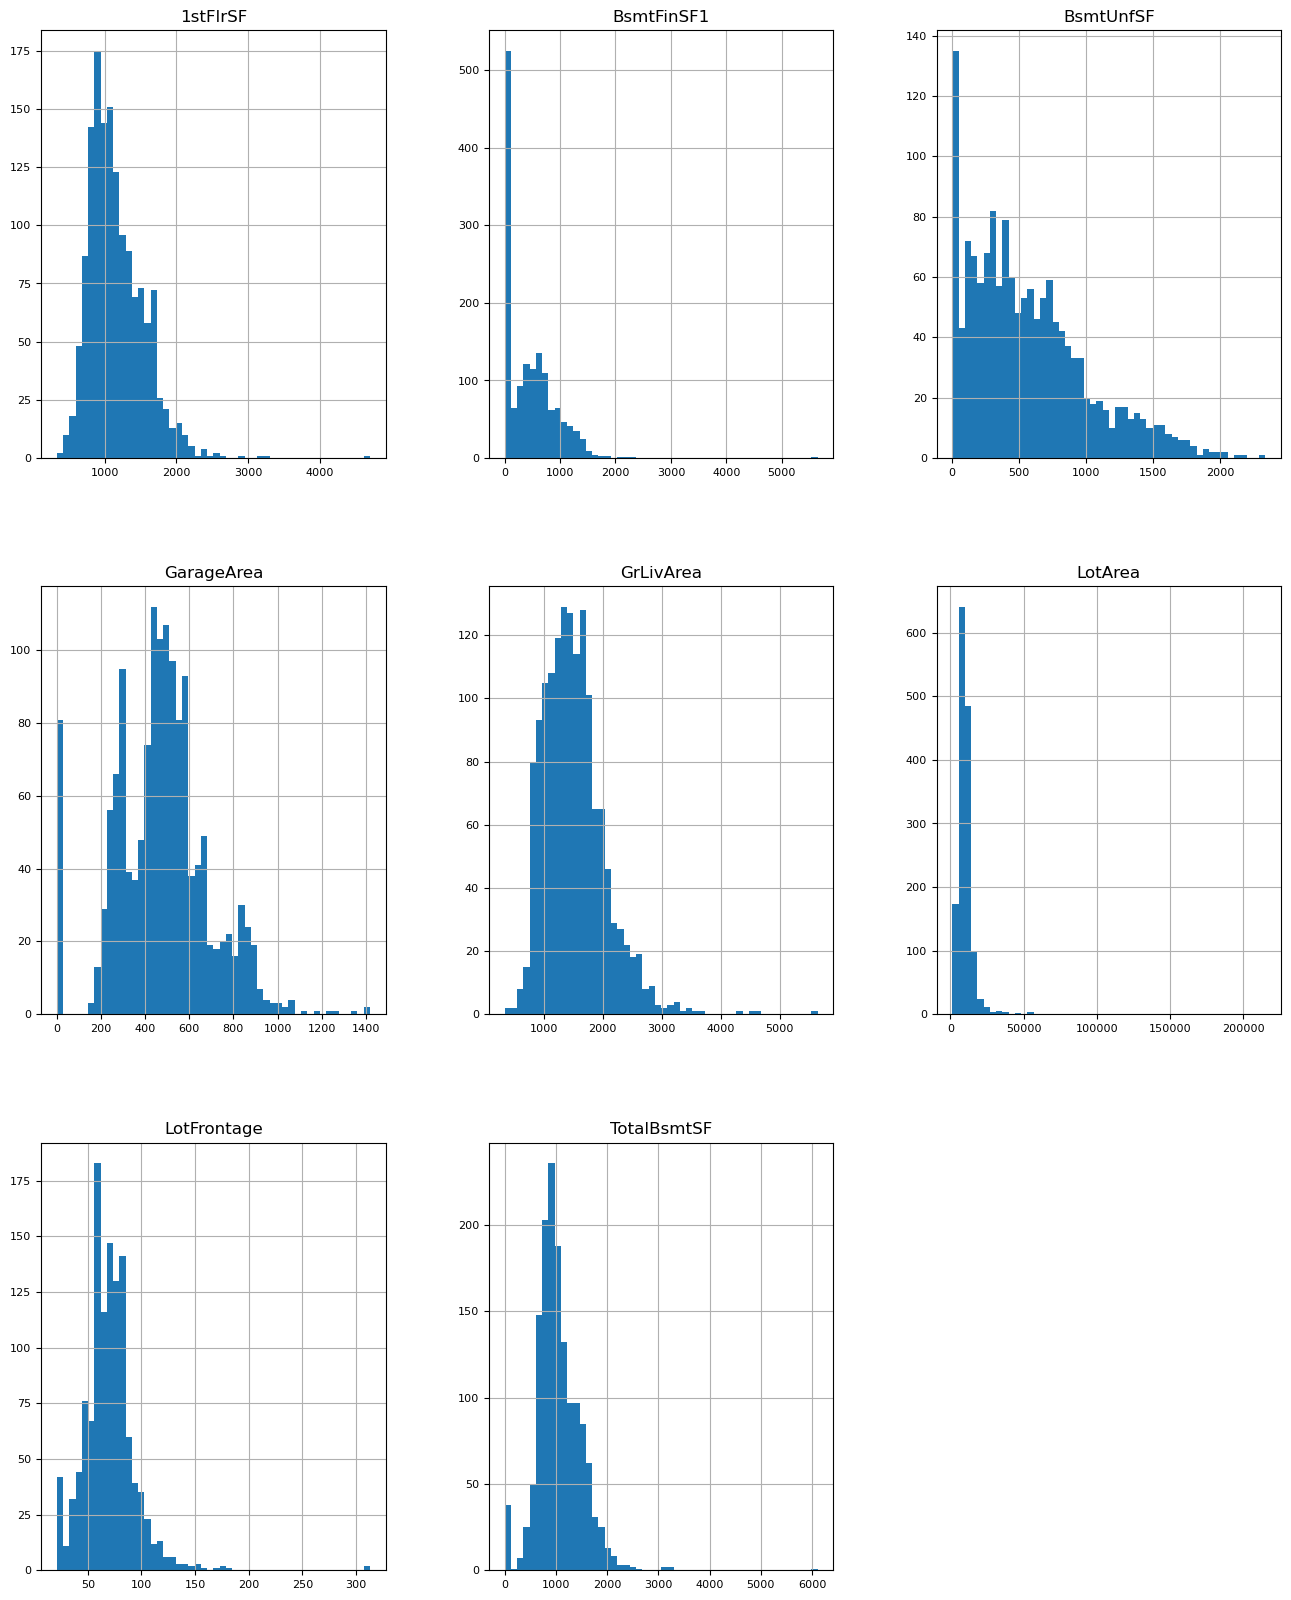

In [268]:
print(f'Numerical features (\033[94m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

print(f'Numerical features (\033[94m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')
X[feature_numerical_uniform].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

print(f'Numerical features (\033[94m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')
X[feature_numerical_norm].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

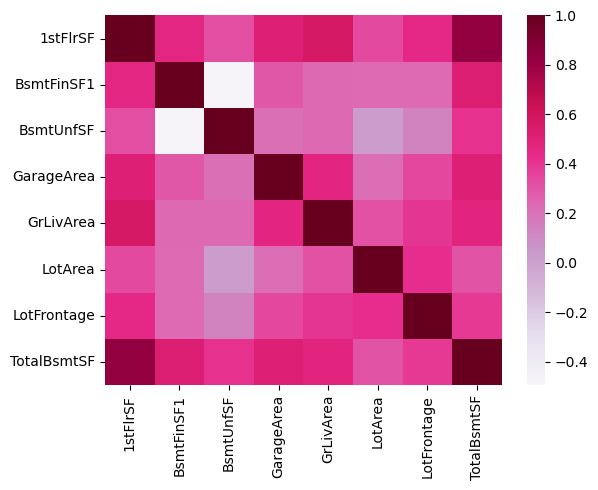

In [239]:
X_num = X[feature_numerical_norm].dropna()

sns.heatmap(X_num.corr(), cmap='PuRd')
pca = PCA()
X_scaled = StandardScaler().fit_transform(X_num)
X_pca = pca.fit_transform(X_scaled)

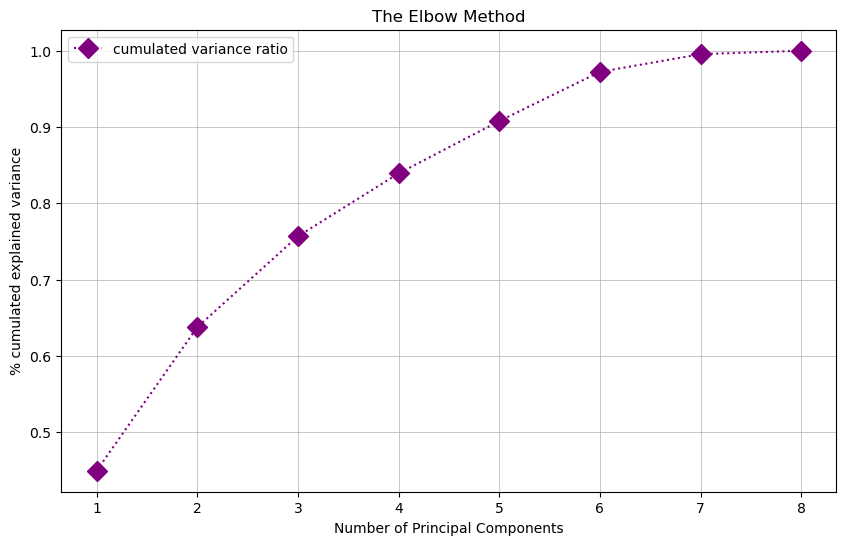

In [269]:
with plt.style.context('seaborn-deep'):
    
    # figsize
    plt.figure(figsize=(10,6))
    
    # getting axes
    ax = plt.gca()
    
    # plotting
    evr_cumulated = np.cumsum(pca.explained_variance_ratio_)
    x_axis_ticks = np.arange(1,evr_cumulated.shape[0]+1)
    ax.plot(x_axis_ticks,evr_cumulated,label="cumulated variance ratio",color="purple",linestyle=":",marker="D",markersize=10)
    
    
    # customizing
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('% cumulated explained variance')
    ax.legend(loc="upper left")
    ax.set_title('The Elbow Method')
    ax.set_xticks(x_axis_ticks)
#     ax.scatter(15,evr_cumulated[15-1],c='blue',s=400)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

## Distribution of each catigorical feature

Categorical cat features (30): ['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofStyle', 'SaleCondition', 'SaleType']


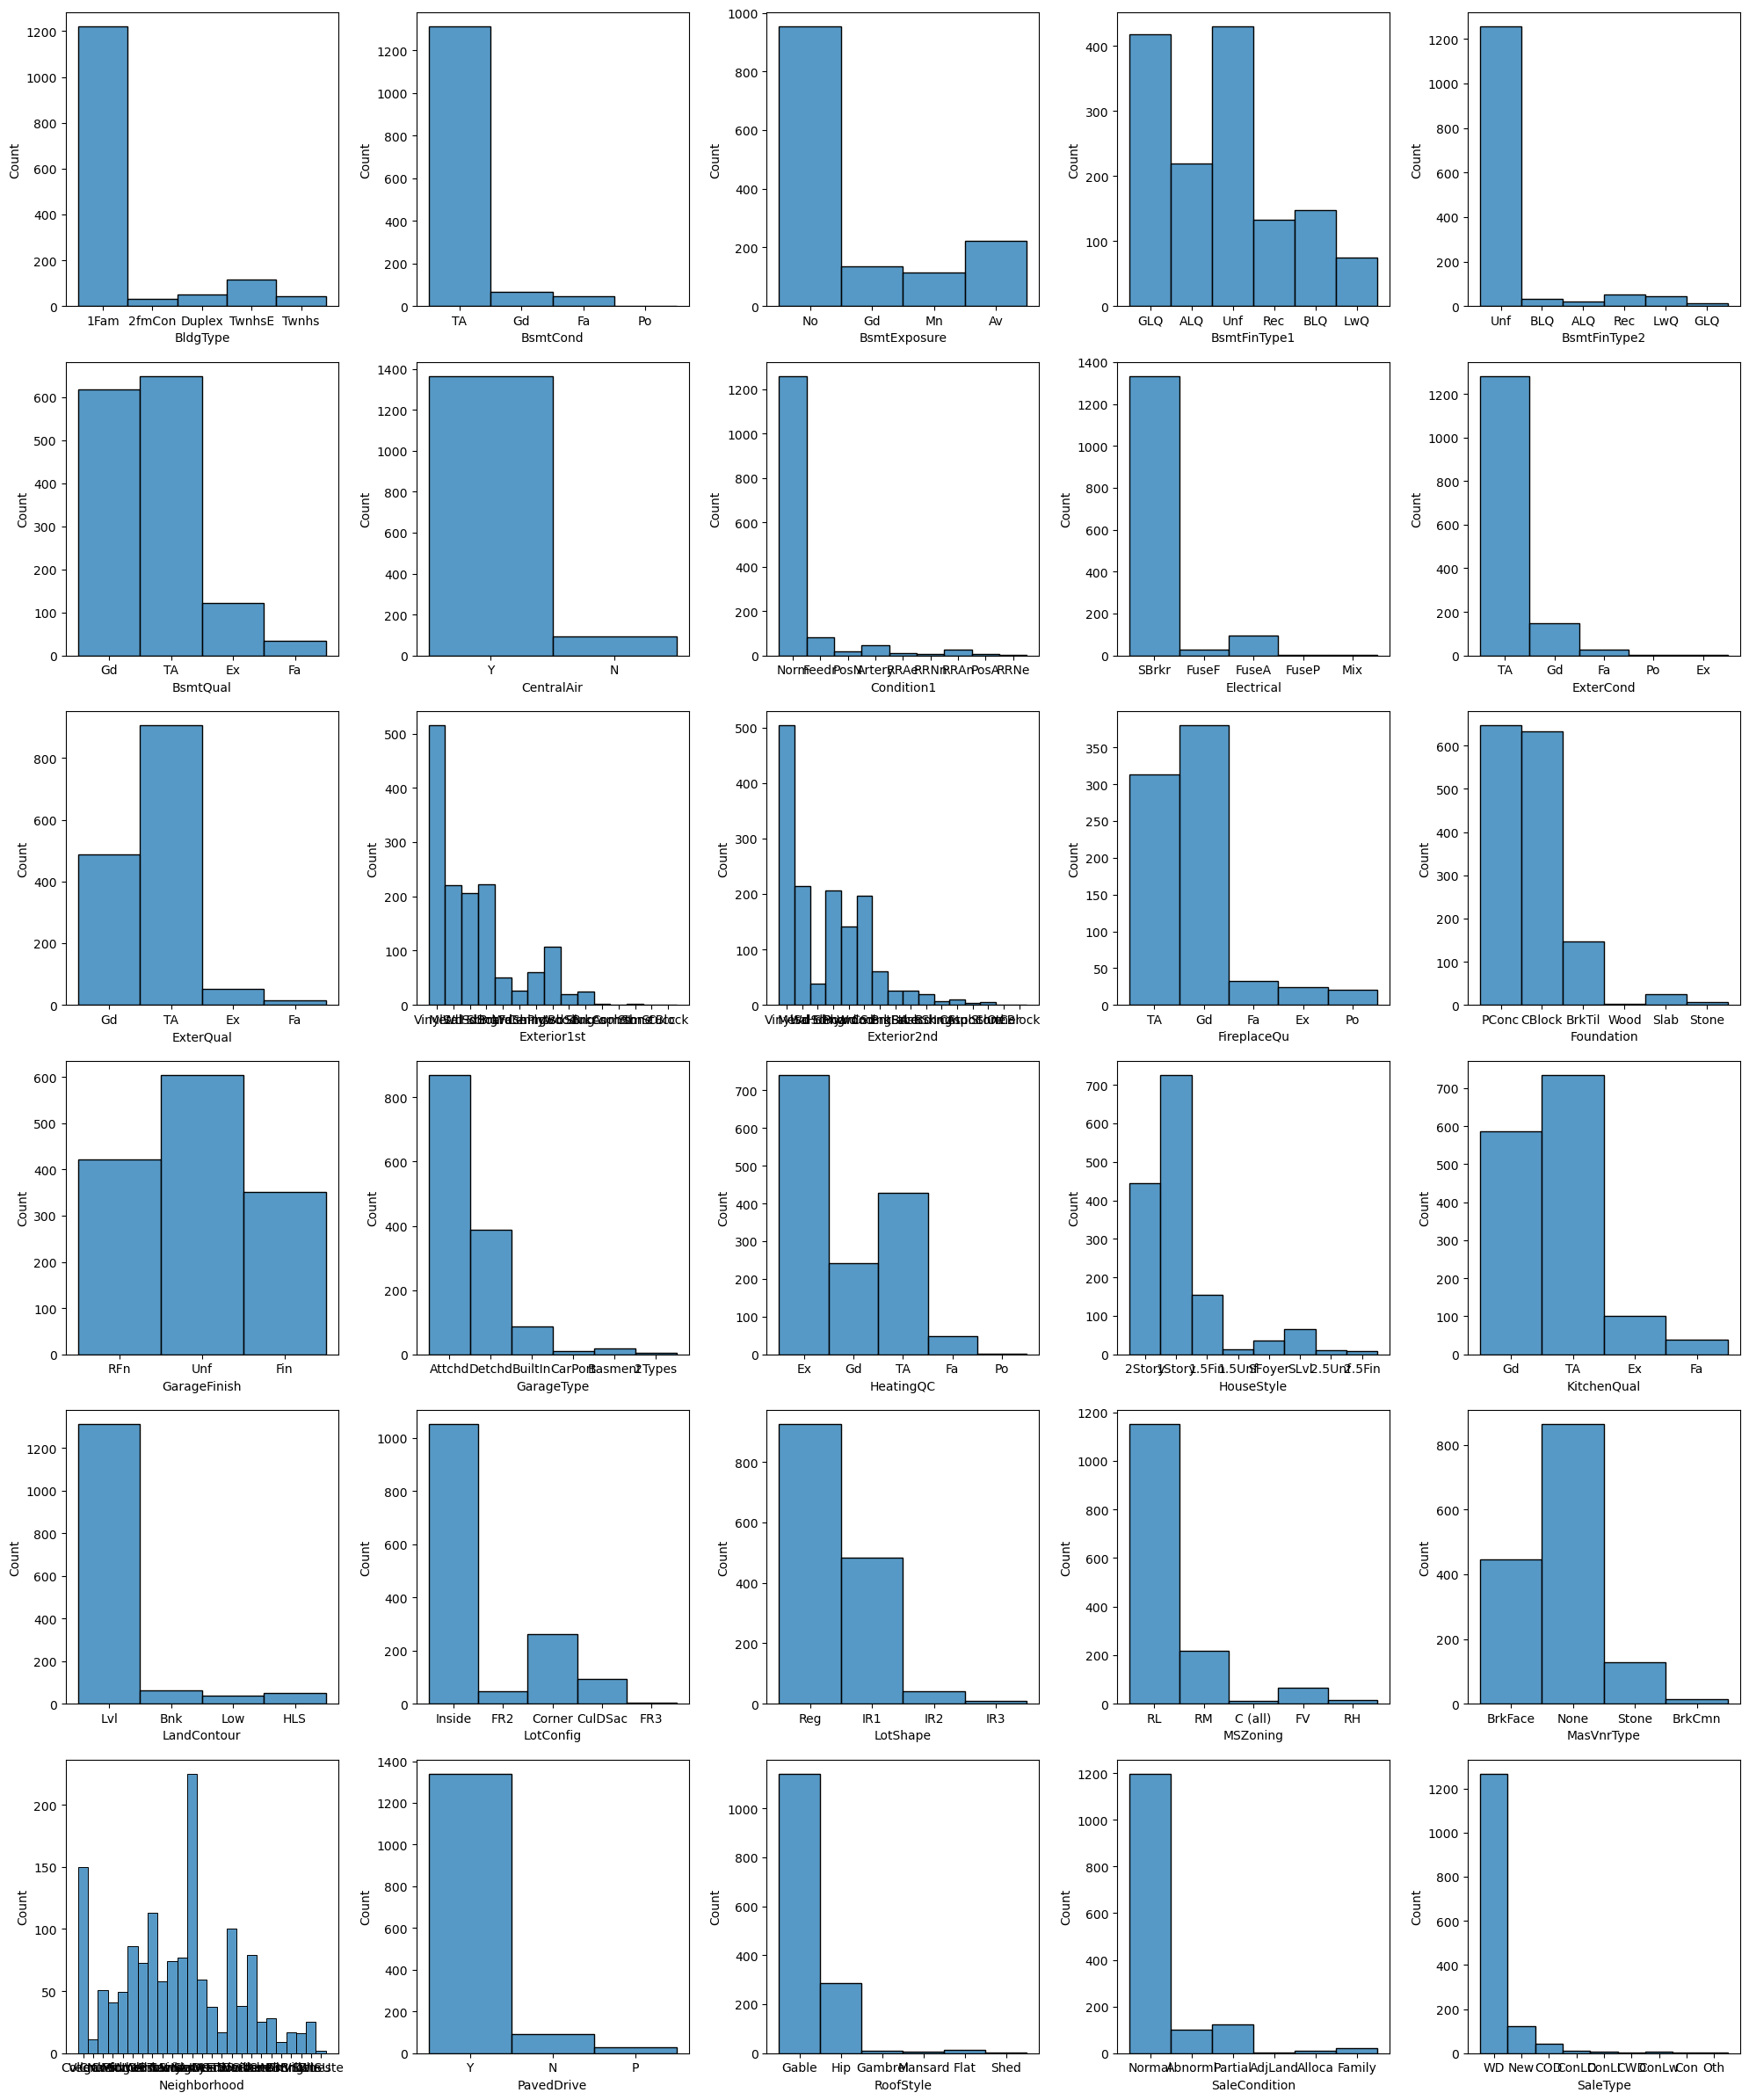

In [270]:
plot_list=feature_categorical

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

# Assuming 'X' is your DataFrame
num_cols = 5  # Number of columns in the grid
num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

# Plot each categorical feature
for i, feature in enumerate(plot_list):
    ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
    sns.histplot(data=X, x=feature, kde=False, ax=ax)

# Hide unused subplots
if len(plot_list) < num_rows * num_cols:
    for j in range(len(plot_list), num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()

## Distribution of each catigorical Ordinal feature

Categorical cat features (7): ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 'HeatingQC', 'KitchenQual']


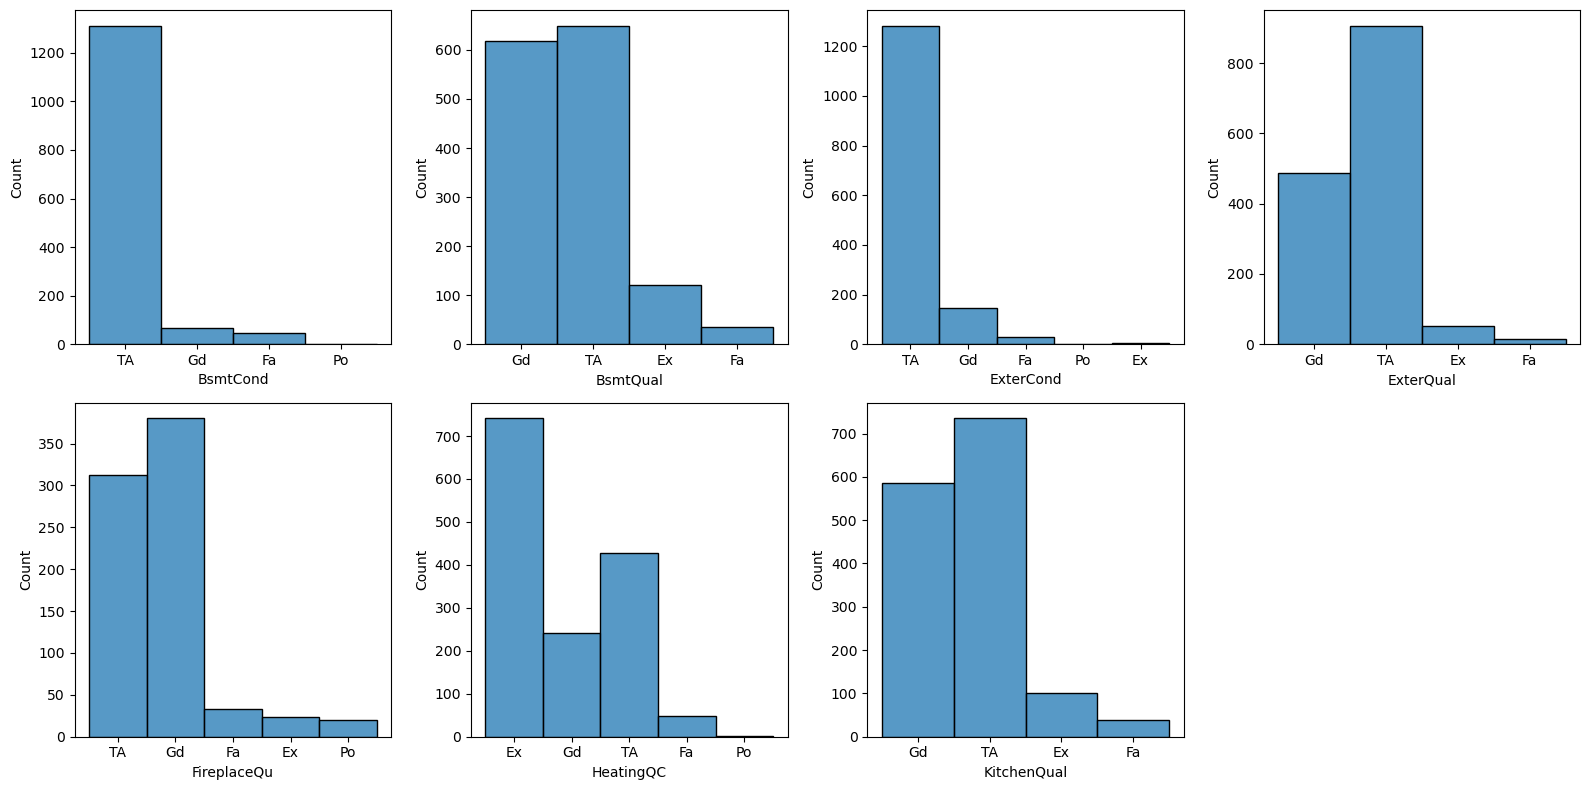

In [271]:
plot_list = feature_categorical_Ordinal

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

In [272]:
feat_ordinal_dict = {
    # considers "missing" as the worse category
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
#     "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
#     "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
#     "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
#     "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
#     "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex']
#     "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
#     "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
#     "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
#     "PavedDrive": ['missing', 'N', 'P', 'Y'],
#     "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}


ordinal_features = list(feat_ordinal_dict.keys())
ordinal_values = list(feat_ordinal_dict.values())
print('complete')

complete


## Distribution of each catigorical OneHot feature

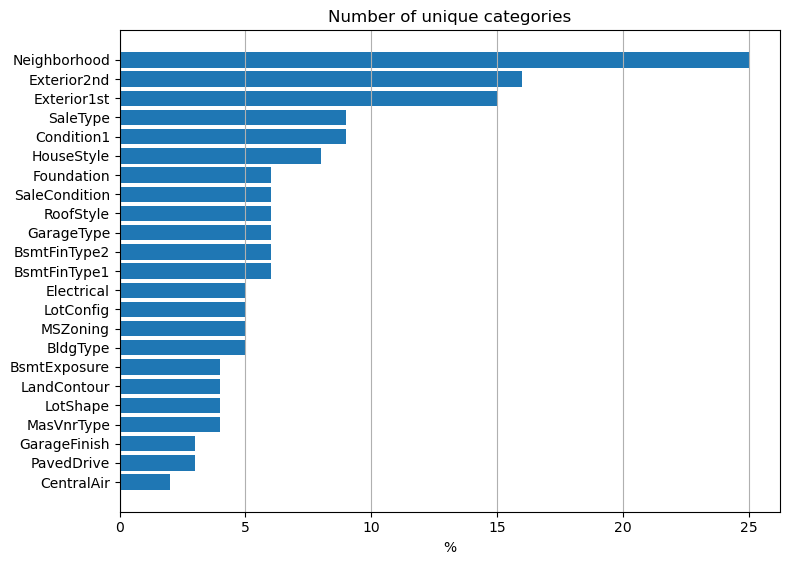

In [273]:
# list the number of categories of each OneHot feature
feature_cat_value_count= X[feature_categorical_OneHot].nunique().sort_values(ascending=False)
feature_cat_value_count=feature_cat_value_count[feature_cat_value_count>0]

# visualize
plt.figure(figsize=(8, feature_cat_value_count.shape[0]/4))
feature_ranks = range(len(feature_cat_value_count))
bar = plt.barh(feature_cat_value_count.index, feature_cat_value_count.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Number of unique categories")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Categorical cat features (23): ['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'Condition1', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageFinish', 'GarageType', 'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofStyle', 'SaleCondition', 'SaleType']


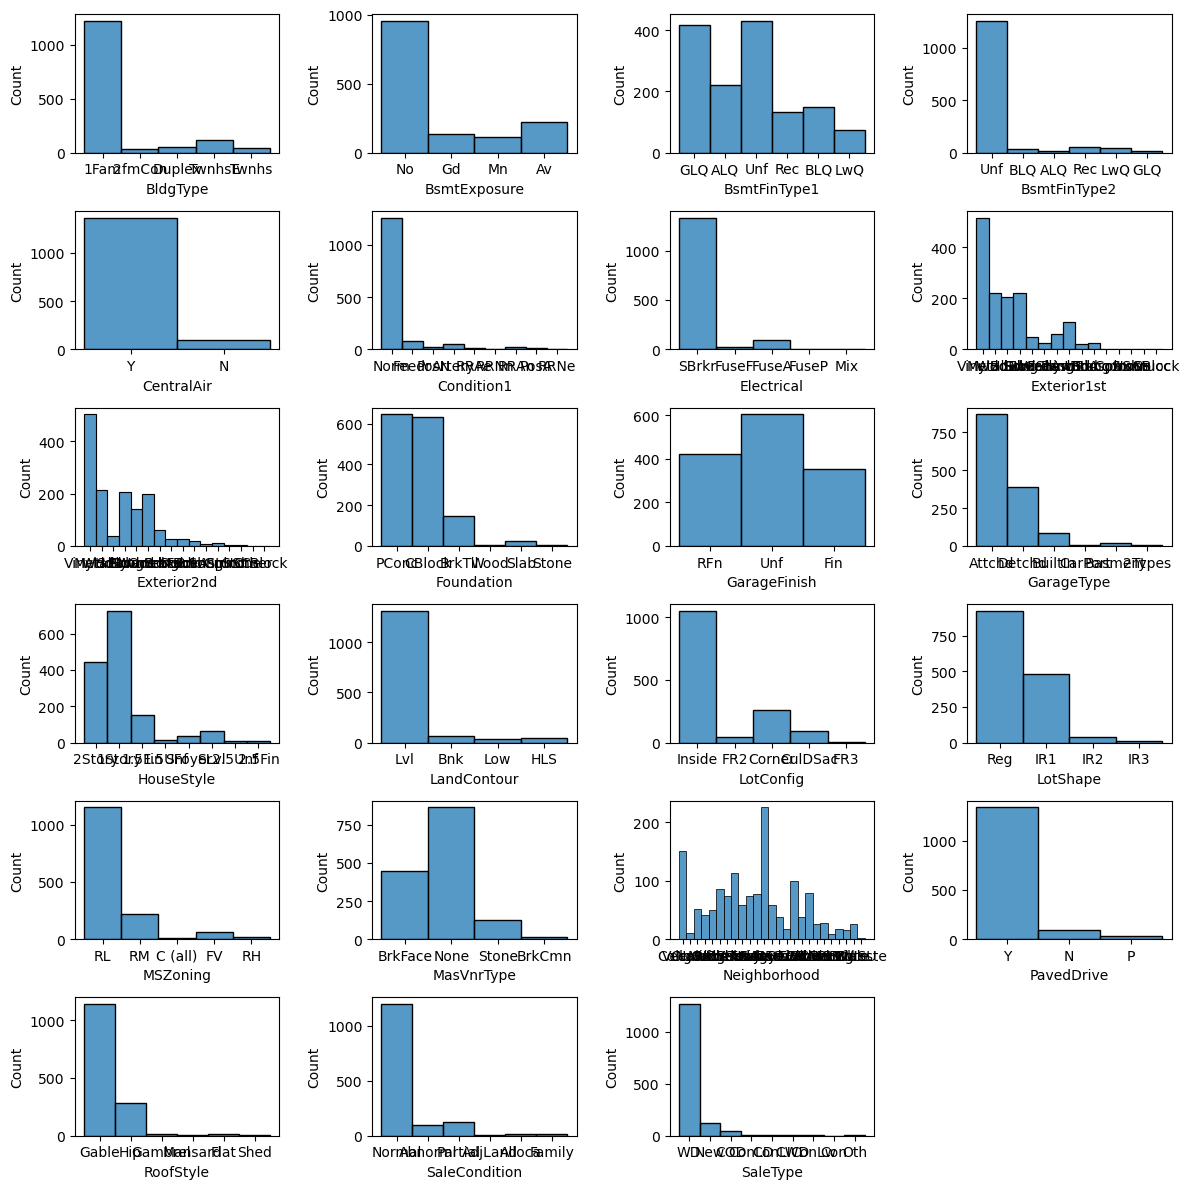

In [274]:
plot_list=feature_categorical_OneHot

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 2*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [275]:
#transformer for numerical data
preproc_num_norm = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler()
    RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_num_uniform = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler(),
    RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_cat_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='Missing'),
    OrdinalEncoder(
        categories=ordinal_values,
        dtype=np.int64,
        handle_unknown="use_encoded_value", unknown_value=-1
    ),
    MinMaxScaler()
)

preproc_cat_onehot = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(
        drop = 'if_binary',
        sparse_output=False,
        handle_unknown='ignore')
)

preproc_pipeline = ColumnTransformer([
    ('ordinal processor', preproc_cat_ordinal, feature_categorical_Ordinal),
    ('numerical processor norm', preproc_num_norm, feature_numerical_norm),
    ('numerical processor uniform', preproc_num_uniform, feature_numerical_uniform),
    ('categorical processor', preproc_cat_onehot, feature_categorical_OneHot),
#     remainder='passthrough'
])

X_preprocessed = preproc_pipeline.fit_transform(X)
y_log=np.log(y)
X_preprocessed.shape, y.shape

((1460, 203), (1460,))

# Models

## Custom Loss Function

In [ ]:
def my_rmsle_neg(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle_neg = make_scorer(my_rmsle_neg)

def my_rmsle(y_true, y_pred):
    return (np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

In [ ]:
def my_rmsle(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

## Cross Validation

In [ ]:
# this code is to use cross validation to screen 
# all available models with default hyperparameters
# please comment out the models which are not relevant

models = {
    'KNN Regressor': KNeighborsRegressor(),
#     'KNN Classifier': KNeighborsClassifier(),
#     'SVC': SVC(),
#     'SVC_poly': SVC(kernel='poly'),
#     'SVC_linear': SVC(kernel='linear'),
    'Decision Tree': DecisionTreeRegressor(),
#     'LinearRegression': LinearRegression(),
#     'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': xgb.XGBRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'lightGBM Regressor': lgb.LGBMRegressor(),
#     'lightGBM Classifier': lgb.LGBMClassifier()
}

print('Baseline Score(s) of each model are ....')
for name in models:
#     cv_result = cross_val_score(models[name], 
#                                 X_fit, 
#                                 y, 
#                                 cv=5, 
#                                 scoring=rmsle_neg, 
#                                 n_jobs=-1)
    cv_result = cross_val_score(models[name], 
                                X_preprocessed, 
                                y_log, 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                n_jobs=-1)
    print(f'Average score: \033[94m{-(-cv_result.mean())**.5}\033[0m by \033[94m{name}\033[0m.')

## Model Tuning

### Gradient Boost

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    model = GradientBoostingRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

gd_study = optuna.create_study(direction='maximize')
gd_study.optimize(objective, n_jobs=-1, n_trials=1000)

best_gd_model = GradientBoostingRegressor(**gd_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(gd_study.best_trial)

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 07:33:19,525] Trial 996 finished with value: -0.14128902086321699 and 
# parameters: {'n_estimators': 384, 'learning_rate': 0.07886590996608028, 'max_depth': 8, 
# 'min_samples_split': 11, 'min_samples_leaf': 1, 'subsample': 0.8477516222094403}. 
# Best is trial 749 with value: -0.13011753420930586.
# 
# FrozenTrial(number=749, state=TrialState.COMPLETE, 
# values=[-0.13011753420930586], datetime_start=datetime.datetime(2023, 5, 29, 7, 28, 3, 12290), 
# datetime_complete=datetime.datetime(2023, 5, 29, 7, 28, 11, 888495), 
# params={
# 'n_estimators': 380, 'learning_rate': 0.05968108162828581, 'max_depth': 3, 
# 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.6630066373055117}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 
# 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.001, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, 
# trial_id=749, value=None)

### KNN

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 3)
    }
    model = KNeighborsRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(objective, n_jobs=-1, n_trials=100)

best_knn_model = KNeighborsRegressor(**knn_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(knn_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 09:48:00,671] Trial 49 finished with value: -0.16731462558226803 and 
# parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. 
# Best is trial 33 with value: -0.1618311568202797.

# FrozenTrial(number=33, state=TrialState.COMPLETE, values=[-0.1618311568202797], 
# datetime_start=datetime.datetime(2023, 5, 29, 9, 47, 59, 746892), 
# datetime_complete=datetime.datetime(2023, 5, 29, 9, 48, 0, 84948), 
# params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}, user_attrs={}, system_attrs={}, 
# intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=10, 
# log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 
# 'p': IntDistribution(high=3, log=False, low=1, step=1)}, trial_id=33, value=None)

In [ ]:
# Bagged KNN
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}
best_knn_model = KNeighborsRegressor(**params)
bagged_knn = BaggingRegressor(best_knn_model, n_estimators=400)
score = np.mean(cross_val_score(bagged_knn, X_fit, y, scoring=rmsle_neg))
print(score)

### XGBoost

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = xgb.XGBRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_jobs=-1, n_trials=1000)

best_xgb_model = xgb.XGBRegressor(**xgb_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(xgb_study.best_trial)

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
#[I 2023-05-29 11:22:38,822] Trial 298 finished with value: -0.12857638901192436 and 
#parameters: {'learning_rate': 0.023101707305620025, 'max_depth': 5, 'n_estimators': 1000, #
# 'subsample': 0.6979913387910185, 'colsample_bytree': 0.5217217192324709, 
# 'reg_alpha': 0.34960671805066684, 'reg_lambda': 0.07718791359911456}. 
# Best is trial 254 with value: -0.12656291447156245.
            
# FrozenTrial(number=254, state=TrialState.COMPLETE, values=[-0.12656291447156245], 
# datetime_start=datetime.datetime(2023, 5, 29, 11, 15, 39, 930104), 
# datetime_complete=datetime.datetime(2023, 5, 29, 11, 17, 0, 694431), 
# params={'learning_rate': 0.027504590029994773, 'max_depth': 4, 'n_estimators': 1000, 
# 'subsample': 0.5663216990626124, 'colsample_bytree': 0.5169119673232286, 
# 'reg_alpha': 0.293253549164087, 'reg_lambda': 0.17096558062613412}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 
# 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=254, value=None)

### Random Foreast

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, step=10),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', None])
    }

    model = RandomForestRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(objective, n_jobs=-1, n_trials=200)

best_rf_model = RandomForestRegressor(**rf_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(rf_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 00:34:28,157] Trial 199 finished with value: -0.1461253165238959 and 
# parameters: {'n_estimators': 910, 'max_depth': 15, 'min_samples_split': 2, 
# 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
# Best is trial 153 with value: -0.14541382928490815.


# FrozenTrial(number=153, state=TrialState.COMPLETE, values=[-0.14541382928490815], 
# datetime_start=datetime.datetime(2023, 5, 29, 0, 31, 32, 480147), 
# datetime_complete=datetime.datetime(2023, 5, 29, 0, 32, 6, 984956), 
# params={'n_estimators': 860, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 
# 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=10), 
# 'max_depth': IntDistribution(high=30, log=False, low=1, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', None))}, 
# trial_id=153, value=None)

### LightGBM

In [ ]:
# Model tuning using uptuna
def objective(trial):
    params = {
        'objective': 'regression',  # or 'regression' for regression problems
        'metric': 'mean_squared_error',  # or 'rmse' for regression problems
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other LightGBM parameters you want to tune
    }
    
    model = lgb.LGBMRegressor(**params)
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

l_gbm_study = optuna.create_study(direction='maximize')
l_gbm_study.optimize(objective, n_jobs=-1, n_trials=50)

best_l_gbm_model = lgb.LGBMRegressor(**l_gbm_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(l_gbm_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 09:40:15,330] Trial 498 finished with value: -0.14083182808996955 and 
# parameters: {'num_leaves': 42, 'learning_rate': 0.08309849556412947}. 
# Best is trial 461 with value: -0.1368568956628003.

# FrozenTrial(number=461, state=TrialState.COMPLETE, values=[-0.1368568956628003], 
# datetime_start=datetime.datetime(2023, 5, 29, 9, 37, 13, 844264), 
# datetime_complete=datetime.datetime(2023, 5, 29, 9, 37, 31, 154074), 
# params={'num_leaves': 10, 'learning_rate': 0.09882489317579622}, user_attrs={}, 
# system_attrs={}, intermediate_values={}, 
# distributions={'num_leaves': IntDistribution(high=1000, log=False, low=10, step=1), 
# 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, 
# trial_id=461, value=None)

### Voting Model

In [ ]:
from sklearn.ensemble import VotingRegressor

r1 = LinearRegression()
r2 = best_rf_model
r3 = best_gd_model
r4 = best_xgb_model

voting_model = VotingRegressor([
    ('lr', r1), 
    ('rf', r2), 
    ('gd', r3), 
    ('gbt', r4)
])

voting_model

In [ ]:
np.mean(cross_val_score(voting_model, X_fit, y, cv=10, scoring=rmsle_neg))

### Neural Network

In [278]:
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

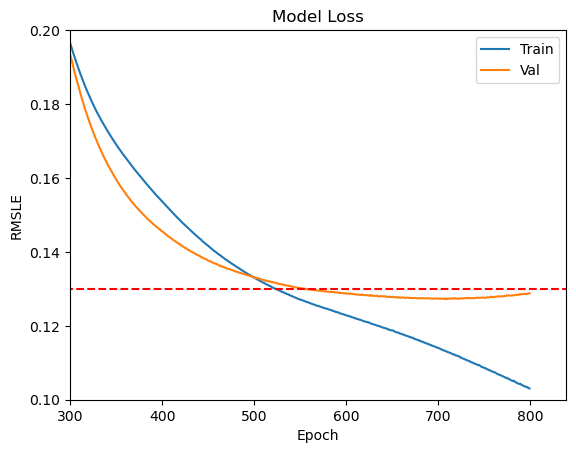

In [279]:
from tensorflow.keras import models, layers
def initialize_model():
    model = models.Sequential([
        layers.Dense(60, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(50, activation='relu'),
#         layers.Dense(10, activation='relu'),
#         layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss='msle',
                  optimizer='adam')
    return model

# Test the Neuroal Network building
model = initialize_model()
# display(model.summary())

history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_val, y_val), 
                    epochs = 800, 
                    batch_size = 32,
                    verbose = 0)
best_nn_model = model

plot_history(history, top=0.2, left=300)

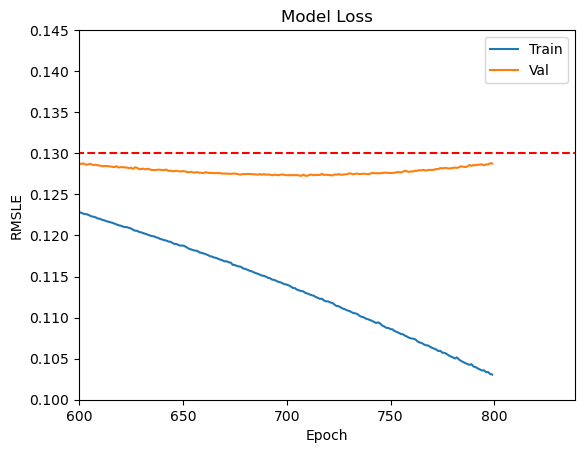

In [280]:
plot_history(history, top=.145, left=600)

#### plot_history()

In [214]:
def plot_history(history, top=100, left=0):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0.1, top=top)
    plt.xlim(left=left)
    plt.legend(['Train', 'Val'], loc='best')
    plt.hlines(y=0.13,  xmin=0, xmax=2000, color='red', linestyles='dashed')
    plt.show()

# Export Result

In [262]:
data_test = pd.read_csv('data/test.csv', index_col='Id')
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [263]:
best_model = best_nn_model
# best_model = best_xgb_model

tuned_pipeline = make_pipeline(
    preproc_pipeline, 
    best_model
)

tuned_pipeline.fit(X, y)
y_pred_baseline=tuned_pipeline.predict(data_test)
df=pd.DataFrame(y_pred_baseline, index=data_test.index, columns=['SalePrice'])
df.to_csv('data/submission_baseline.csv', index = True)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_60/dense_233/Relu' defined at (most recent call last):
    File "/Users/haitao/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/haitao/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/haitao/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/haitao/anaconda3/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/haitao/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/r4/9ch2b93x7yd208vwqjxkx9180000gn/T/ipykernel_29843/1193462406.py", line 9, in <module>
      tuned_pipeline.fit(X, y)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
      self._final_estimator.fit(Xt, y, **fit_params_last_step)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/Users/haitao/anaconda3/lib/python3.10/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_60/dense_233/Relu'
Matrix size-incompatible: In[0]: [32,203], In[1]: [249,60]
	 [[{{node sequential_60/dense_233/Relu}}]] [Op:__inference_train_function_8370538]

In [ ]:
import xgboost as xgb

xgb.get_config()